In [35]:
import torch 
from torch.utils.data import Dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
from jetnet.datasets import JetNet

class JetClassDataset(Dataset):

    def __init__(self, num_particles=30, jet_types=["g", "q", "t", "w", "z"], preprocess=None):
        
        self.num_particles = num_particles
        self.jet_types = jet_types if isinstance(jet_types, list) else [jet_types]
        self.preprocess_methods = preprocess 
        self.summary_stats = None
    
        ''' data attributes:
            - target: jetnet data
            - target_preprocessed:  jetnet data with preprocessing
            - source: std gaussian noise
        '''

        self.get_target_data()
        self.get_source_data()

    def __getitem__(self, idx):
        output = {}
        output['particle features'] = self.particles_preprocess[idx]
        output['mask'] = self.mask[idx]
        output['jet features'] = self.jets[idx]
        output['flavor'] = self.flavor[idx]
        output['source'] = self.source[idx]
        return output

    def __len__(self):
        return self.jets.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):

        args = {"jet_type": self.jet_types,  
                "data_dir": "../data/jetnet" + str(self.num_particles),
                "particle_features": ["etarel", "phirel", "ptrel", "mask"],
                "num_particles": self.num_particles,
                "jet_features": ["type", "pt", "eta", "mass"]}

        particle_data, jet_data = JetNet.getData(**args)
        self.particles = torch.Tensor(particle_data[..., :-1])
        self.mask = torch.Tensor(particle_data[..., -1])
        self.jets = torch.Tensor(jet_data[..., 1:])
        self.flavor= torch.Tensor(jet_data[..., 0])
        particles = PreProcessJetNetData(self.particles, methods=self.preprocess_methods)
        particles.preprocess()
        self.summary_stats = particles.summary_stats
        self.particles_preprocess = particles.features.clone()

    def get_source_data(self):
        self.source = torch.randn_like(self.particles, dtype=torch.float32)



class PreProcessJetNetData:

    def __init__(self, 
                 data, 
                 methods: list=None
                 ):
        
        self.features = data
        self.methods = methods
        self.summary_stats = {}

    def preprocess(self):        
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass
    
    def standardize(self,  sigma: float=1.0):
        """ standardize data to have zero mean and unit variance
        """
        self.summary_stats['mean'] = torch.mean(self.features, dim=0)
        self.summary_stats['std'] = torch.std(self.features, dim=0)
        self.features = (self.features - self.summary_stats['mean']) * (sigma / self.summary_stats['std'])


class PostProcessJetNetData:

    def __init__(self, 
                 data, 
                 summary_stats,
                 methods: list=None
                 ):
        
        self.features = data
        self.summary_stats = summary_stats
        self.methods = methods

    def postprocess(self):
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Postprocessing method {} not implemented'.format(method))
        else: pass

    def inverse_standardize(self,  sigma: float=1.0):
        self.features = self.features * (self.summary_stats['std'] / sigma) + self.summary_stats['mean']
    


tops = JetNetDataset(jet_types="t", preprocess=["standardize"])
wboson = JetNetDataset(jet_types="w", preprocess=["standardize"])
jets = JetNetDataset(jet_types=["g", "q"], preprocess=["standardize"])


In [67]:
# make histograms for dataset

def feature_plots(jetnet_data, features=[r'$\Delta\eta$', r'$\Delta\phi$', r'$p^{\rm rel}_T$'], num_particles=100000, color='blue'):
    _, axs = plt.subplots(1, 3, figsize=(7, 2.5))
    axs[0].hist(jetnet_data[..., 0].flatten()[:num_particles], bins=100,log=True, color='gold')
    axs[1].hist(jetnet_data[..., 1].flatten()[:num_particles], bins=100, log=True, color='darkblue')
    axs[2].hist(jetnet_data[..., 2].flatten()[:num_particles], bins=100, log=True, color='darkred')
    axs[0].set_xlabel(features[0])
    axs[1].set_xlabel(features[1])
    axs[2].set_xlabel(features[2])
    axs[0].set_ylabel('counts')
    plt.tight_layout()
    plt.show()

### Raw particle data

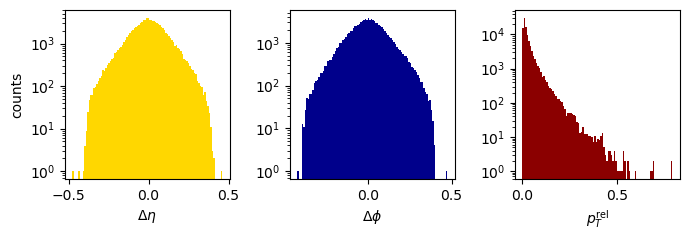

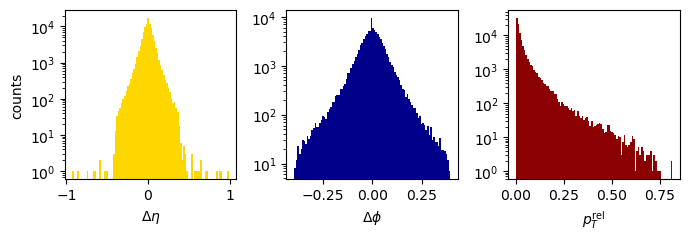

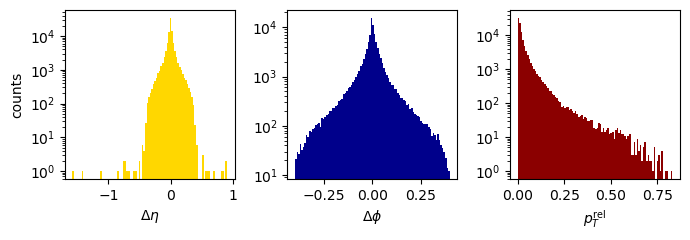

In [68]:
feature_plots(tops.particles)
feature_plots(wboson.particles)
feature_plots(jets.particles)


### Raw jet data

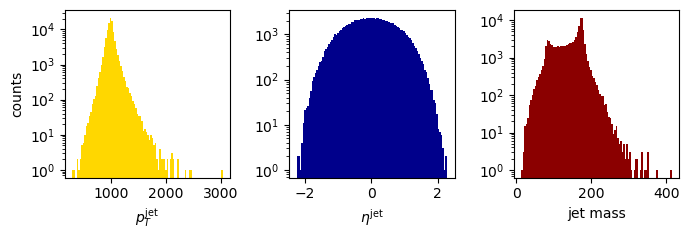

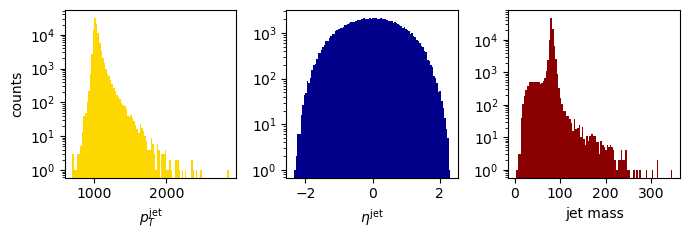

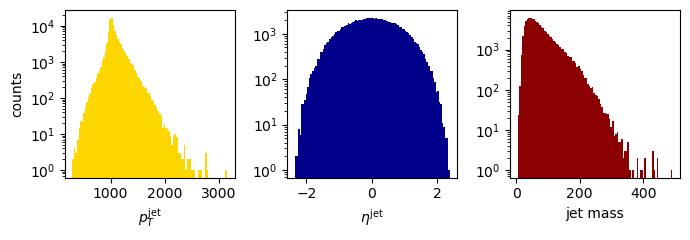

In [71]:
feature_plots(tops.jets, features=[r'$p^{\rm jet}_T$', r'$\eta^{\rm jet}$', r'jet mass'])
feature_plots(wboson.jets, features=[r'$p^{\rm jet}_T$', r'$\eta^{\rm jet}$', r'jet mass'])
feature_plots(jets.jets, features=[r'$p^{\rm jet}_T$', r'$\eta^{\rm jet}$', r'jet mass'])

### Pre-processed particle data

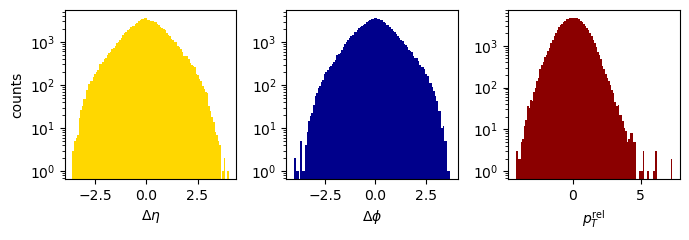

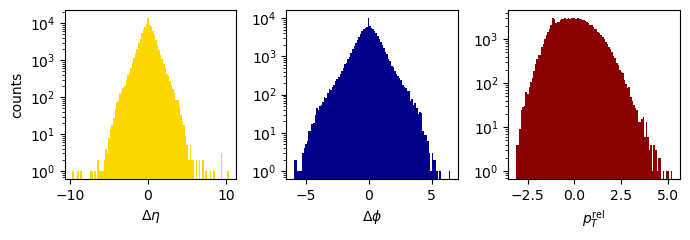

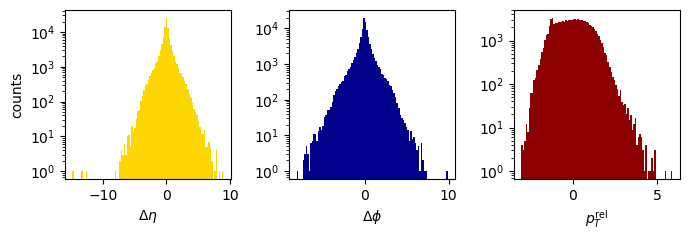

In [70]:
feature_plots(wboson.particles_preprocess)
feature_plots(wboson.particles_preprocess)
feature_plots(jets.particles_preprocess)

### Xcheck post-processing

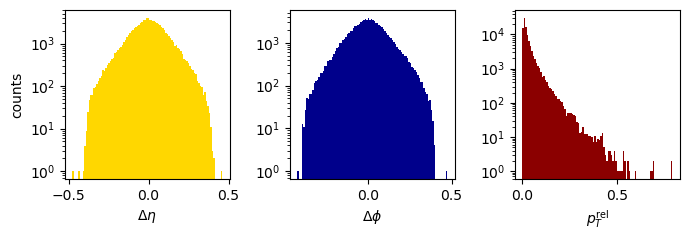

In [75]:
tops_post = PostProcessJetNetData(tops.particles_preprocess, summary_stats=tops.summary_stats, methods=["inverse_standardize"])
tops_post.postprocess()

feature_plots(tops_post.features)
